# GMAC Acceleration Magnitude: Grid search of GMAC parameters

The acceleration magnitude estimation for the GMAC algorithm has the following parameters:
1. Butteworth highpass filter cut-off for accl. mag. estimation. $\left( f_{c} \right)$
2. Butteworth highpass filter order for accl. mag. estimation. $\left( n_{c} \right)$
3. Acceleration deadband threshold. $\left( a_{th0} \right)$
4. Moving average window for acceleration magnitude estimation. $\left( n_{am} \right)$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [46]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [3]:
import seaborn as sns

In [4]:
# Define a dictionary containing the font settings for LaTeX
latex_font = {
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",  # Optional: Include additional LaTeX packages
    "font.family": "serif",  # Use a serif font (e.g., Times New Roman)
    "font.serif": ["Times New Roman"],  # Specify the font family
}

# Update the Matplotlib configuration with the LaTeX font settings
plt.rcParams.update(latex_font)

### Custom Modules

In [8]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [9]:
import gmac

In [10]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [11]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [13]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

#### Parameter ranges for the grid search

In [47]:
basedir = "../data/output"

# Make directory if it does not exist
outdir = pathlib.Path(basedir, "am")
outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
am_param_ranges = {
    "fc": [0.01, 0.1, 1],
    "nc": [1, 2, 4],
    "nam": list(map(int, [Fs, 5*Fs, 10*Fs]))
}

# Save params file.
with open(pathlib.Path(outdir, "am_params.json"), "w") as f:
    json.dump(am_param_ranges, f, indent=4)

dfcols = ["subject"] + list(am_param_ranges.keys()) + ["am", "vm"]

In [19]:
for limbkey in ["left", "right", "aff", "unaff"]:
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Number of all possible combinations
    Ncombs = len(list(misc.generate_param_combinations_am(am_param_ranges)))

    # All parameter combinations.
    param_combs = list(misc.generate_param_combinations_am(am_param_ranges))

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']
    dfcols = ["subject"] + list(am_param_ranges.keys()) + ["am", "vm"]

    for i, subj in enumerate(subjects):
        am_df = pd.DataFrame(columns=dfcols)
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute the vector magnitude
            _vmdf = misc.compute_vector_magnitude(df)
            # Compute the accl magnitude
            _tempam = gmac.estimate_accl_mag(accl=df[accl_cols].values,
                                            fs=Fs, fc=_pc["fc"], nc=_pc["nc"],
                                            n_am=_pc["nam"])
            _tempamdf = pd.DataFrame(np.vstack((_tempam, df.segment.values)).T,
                                    columns=["am", "segment"], index=df.index)
            # Resample accl magnitude to the same frequency as vector magnitude
            _amdf = pd.concat([_y.resample(str(1) + 'S').sum()
                            for _, _y in _tempamdf.groupby('segment')])
            
            # Merge the two dataframes
            _tempdf = pd.merge(_vmdf, _amdf["am"], left_index=True, right_index=True)

            # Update amdf
            _n = len(_tempdf)
            _subj_am = np.hstack((subj * np.ones((_n, 1)),
                                _pc["fc"] * np.ones((_n, 1)),
                                _pc["nc"] * np.ones((_n, 1)),
                                _pc["nam"] * np.ones((_n, 1)),
                                _tempdf.am.values.reshape(-1, 1),
                                _tempdf.counts.values.reshape(-1, 1)))
            am_df = pd.concat((am_df, pd.DataFrame(_subj_am, columns=dfcols)),
                            ignore_index=True)
        # Save data regularly
        am_df.to_csv(pathlib.Path(outdir, f"raw_am_{limbkey}_{subj}.csv").as_posix(), index=False)


unaff   4,  26

## Analyse effect of different parameters

['../data/output/am/raw_am_unaff_1.csv',
 '../data/output/am/raw_am_unaff_3.csv',
 '../data/output/am/raw_am_unaff_2.csv',
 '../data/output/am/raw_am_unaff_5.csv',
 '../data/output/am/raw_am_unaff_4.csv']

In [53]:
# Read and combine data from different subjects in one file.
all_am_df = {
    _lmb: pd.concat([pd.read_csv(f) for f in glob.glob(pathlib.Path(outdir).as_posix()
                                                       + f"/raw_am_{_lmb}*.csv")],
                    ignore_index=True)
    for _lmb in ["left", "right", "aff", "unaff"]
}

In [54]:
# Compute correlation for all limbs
am_corr_df = pd.DataFrame(columns=["subject", "limb", "fc", "nc", "nam", "r", "p"])
for _lmb in ["left", "right", "aff", "unaff"]:
    param_combs = list(misc.generate_param_combinations_am(am_param_ranges))

    # Effect of fc
    _limbdf = all_am_df[_lmb]
    cols = ["subj", "fc", "nc", "nam", "r", "p"]
    # am_corr_df[_lmb] = pd.DataFrame(columns=cols)
    for i, subj in enumerate(_limbdf["subject"].unique()):
        # am_df = pd.DataFrame(columns=dfcols)
        # Go through all parameter combinations.
        _sinx = _limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            # Parameter index
            _pcinx = ((_limbdf["fc"] == _pc["fc"]) &
                      (_limbdf["nc"] == _pc["nc"]) &
                      (_limbdf["nam"] == _pc["nam"]))
            _vm = _limbdf.loc[_sinx & _pcinx]["vm"].values
            _am = _limbdf.loc[_sinx & _pcinx]["am"].values
            _inx = np.where(~np.isnan(_vm) & ~np.isnan(_am))[0]
            _r, _p = scipy.stats.spearmanr(_vm[_inx], _am[_inx])
            # Update amdf
            am_corr_df = pd.concat(
                (am_corr_df,
                 pd.DataFrame.from_dict({
                    "subject": [subj],
                    "limb": [_lmb],
                    "fc": [_pc["fc"]],
                    "nc": [_pc["nc"]],
                    "nam": [_pc["nam"]],
                    "r": [_r],
                    "p": [_p]
                 })),
                ignore_index=True
            )
am_corr_df.to_csv(pathlib.Path(outdir, "perf_am_est.csv").as_posix(), index=False)

## Summary plots

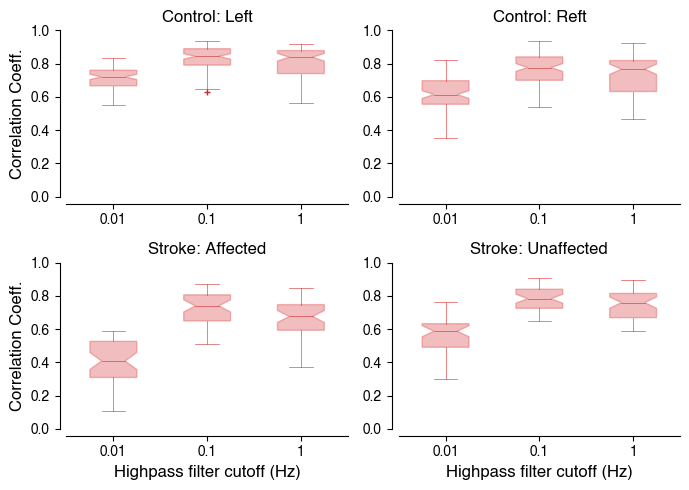

In [29]:
# Effect fc
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["fc"]):
        _inx = am_corr_df[_lmb]["fc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        # ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["fc"])

plt.tight_layout()

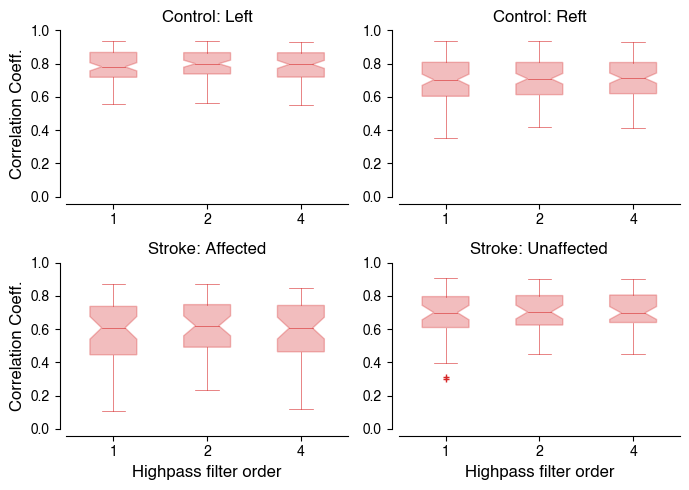

In [41]:
# Effect nc
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["nc"]):
        _inx = am_corr_df[_lmb]["nc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        # ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter order", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["nc"])

plt.tight_layout()

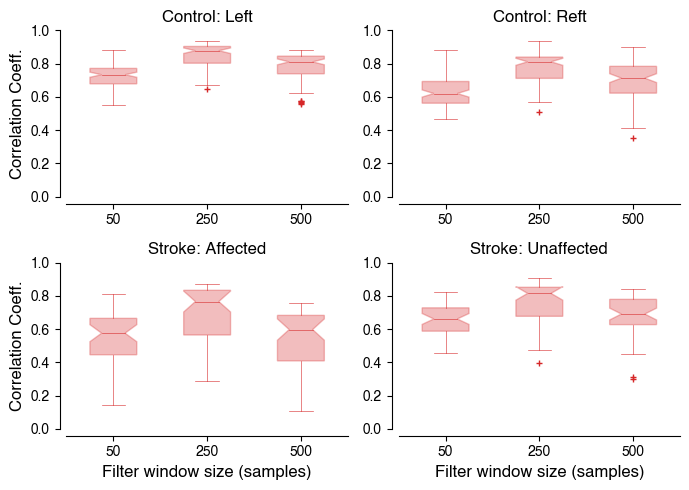

In [43]:
# Effect nam
fig = plt.figure(figsize=(7, 5))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _val in enumerate(am_param_ranges["nam"]):
        _inx = am_corr_df[_lmb]["nam"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Filter window size (samples)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)

    ax.set_xticklabels(am_param_ranges["nam"])
plt.tight_layout()

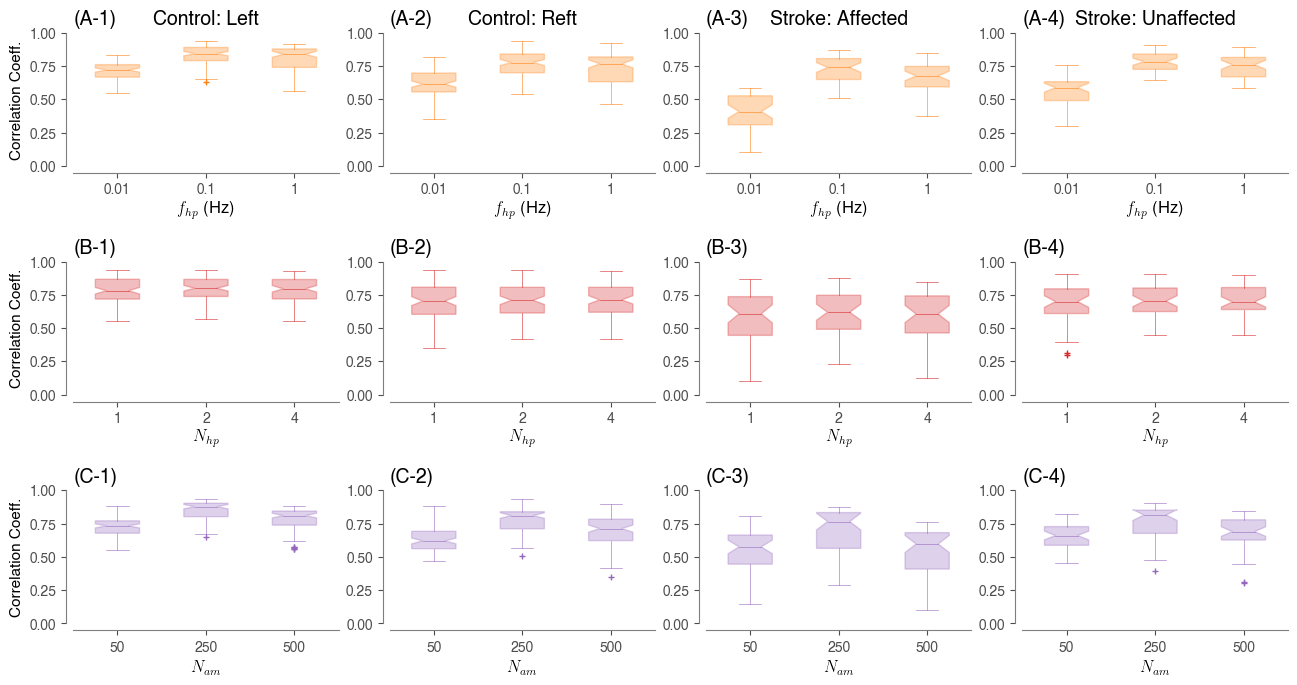

In [40]:
# Effect fc
fig = plt.figure(figsize=(13, 7))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    # Effect of fc
    ax = fig.add_subplot(3, 4, j+1)
    for i, _val in enumerate(am_param_ranges["fc"]):
        _inx = am_corr_df[_lmb]["fc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:orange", color="tab:orange", alpha=0.3),
                   capprops=dict(color="tab:orange", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:orange", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:orange", markeredgecolor="tab:orange",
                                   markerfacecolor='tab:orange', marker='+', markersize=4),
                   medianprops=dict(color="tab:orange", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        ax.tick_params(axis='x', colors='0.3')
        ax.tick_params(axis='y', colors='0.3')
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=14)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=14)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=14)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=14)
        
        ax.set_xlabel(r"$f_{hp}$ (Hz)", fontsize=12, usetex=True)
        if j % 4 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=11, usetex=False)
    ax.text(0, 1.175, f'(A-{j+1})', fontsize=14,
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xticklabels(am_param_ranges["fc"])

for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    # Effect of nc
    ax = fig.add_subplot(3, 4, j+5)
    for i, _val in enumerate(am_param_ranges["nc"]):
        _inx = am_corr_df[_lmb]["nc"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                   capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                   markerfacecolor='tab:red', marker='+', markersize=4),
                   medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        ax.tick_params(axis='x', colors='0.3')
        ax.tick_params(axis='y', colors='0.3')
        ax.set_xlabel(r"$N_{hp}$", fontsize=12, usetex=True)
        if j % 4 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=11)
    ax.text(0, 1.175, f'(B-{j+1})', fontsize=14,
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xticklabels(am_param_ranges["nc"])

for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(3, 4, j+9)
    for i, _val in enumerate(am_param_ranges["nam"]):
        _inx = am_corr_df[_lmb]["nam"] == _val
        _r = am_corr_df[_lmb][_inx]["r"].values
        ax.boxplot(x=_r, positions=[i],
                   widths=0.5, notch=True, patch_artist=True,
                   boxprops=dict(facecolor="tab:purple", color="tab:purple", alpha=0.3),
                   capprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
                   whiskerprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
                   flierprops=dict(color="tab:purple", markeredgecolor="tab:purple",
                                   markerfacecolor='tab:purple', marker='+', markersize=4),
                   medianprops=dict(color="tab:purple", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_xlabel(r"$N_{am}$", fontsize=12, usetex=True)
        ax.spines['left'].set_color("tab:gray")
        ax.spines['bottom'].set_color("tab:gray")
        ax.tick_params(axis='x', colors='0.3')
        ax.tick_params(axis='y', colors='0.3')
        if j % 4 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=11, usetex=False)
    ax.text(0, 1.175, f'(C-{j+1})', fontsize=14,
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xticklabels(am_param_ranges["nam"])

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"am_gmac.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"am_gmac.svg"), bbox_inches="tight")

## Statitical Analysis of the parameters

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
am_corr_df["left"]["subj"] = am_corr_df["left"]["subj"].astype(int)
am_corr_df["left"]["nam"] = am_corr_df["left"]["nam"].astype(int)
am_corr_df["right"]["subj"] = am_corr_df["right"]["subj"].astype(int)
am_corr_df["right"]["nam"] = am_corr_df["right"]["nam"].astype(int)
am_corr_df["aff"]["subj"] = am_corr_df["aff"]["subj"].astype(int)
am_corr_df["aff"]["nam"] = am_corr_df["aff"]["nam"].astype(int)
am_corr_df["unaff"]["subj"] = am_corr_df["unaff"]["subj"].astype(int)
am_corr_df["unaff"]["nam"] = am_corr_df["unaff"]["nam"].astype(int)

In [44]:
lme_left = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["left"],
                       groups=am_corr_df["left"]["subj"])
lme_left.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0066  
Min. group size:  27      Log-Likelihood:     265.7766
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.738    0.018 40.283 0.000  0.702  0.774
fc           0.048    0.011  4.341 0.000  0.026  0.070
nc          -0.000    0.004 -0.072 0.943 -0.008  0.007
nam          0.000    0.000  4.039 0.000  0.000  0.000
Group Var    0.002    0.011                           
======================================================

"""

In [45]:
lme_right = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["right"],
                       groups=am_corr_df["right"]["subj"])
lme_right.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0093  
Min. group size:  27      Log-Likelihood:     217.1140
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.643    0.027 24.120 0.000  0.591  0.695
fc           0.044    0.013  3.349 0.001  0.018  0.070
nc           0.005    0.005  0.963 0.336 -0.005  0.014
nam          0.000    0.000  4.127 0.000  0.000  0.000
Group Var    0.005    0.025                           
======================================================

"""

In [46]:
lme_aff = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["aff"],
                       groups=am_corr_df["aff"]["subj"])
lme_aff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: r      
No. Observations: 135     Method:             REML   
No. Groups:       5       Scale:              0.0263 
Min. group size:  27      Log-Likelihood:     33.9370
Max. group size:  27      Converged:          Yes    
Mean group size:  27.0                               
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.551    0.052 10.660 0.000  0.449  0.652
fc          0.119    0.031  3.819 0.000  0.058  0.180
nc          0.001    0.011  0.126 0.900 -0.021  0.023
nam        -0.000    0.000 -0.363 0.716 -0.000  0.000
Group Var   0.006    0.032                           
=====================================================

"""

In [47]:
lme_unaff = smf.mixedlm("r ~ fc + nc + nam", data=am_corr_df["unaff"],
                       groups=am_corr_df["unaff"]["subj"])
lme_unaff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: r      
No. Observations: 135     Method:             REML   
No. Groups:       5       Scale:              0.0131 
Min. group size:  27      Log-Likelihood:     80.0862
Max. group size:  27      Converged:          Yes    
Mean group size:  27.0                               
-----------------------------------------------------
            Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.643    0.035 18.444 0.000  0.574  0.711
fc          0.092    0.022  4.159 0.000  0.048  0.135
nc          0.004    0.008  0.569 0.569 -0.011  0.020
nam         0.000    0.000  0.620 0.535 -0.000  0.000
Group Var   0.003    0.019                           
=====================================================

"""

### With interactions

In [50]:
lme_left = smf.mixedlm("r ~ fc + nc + nam + fc * nc + fc * nam + nc * nam + fc * nc * nam", data=am_corr_df["left"],
                       groups=am_corr_df["left"]["subj"])
lme_left.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0061  
Min. group size:  27      Log-Likelihood:     245.3135
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.764    0.026 28.996 0.000  0.712  0.815
fc          -0.042    0.040 -1.052 0.293 -0.120  0.036
nc           0.000    0.009  0.047 0.962 -0.017  0.018
nam          0.000    0.000  0.383 0.702 -0.000  0.000
fc:nc        0.007    0.015  0.484 0.628 -0.022  0.037
fc:nam       0.000    0.000  2.436 0.015  0.000  0.001
nc:nam      -0.000    0.000 -0.319 0.750 -0.000  0.000
fc:nc:nam   -0.000    0.000 -0.240 0.810 -0.000  0.000
Group Var    0.002    0.011                           
======================================================

"""

In [51]:
lme_right = smf.mixedlm("r ~ fc + nc + nam + fc * nc + fc * nam + nc * nam + fc * nc * nam", data=am_corr_df["right"],
                       groups=am_corr_df["right"]["subj"])
lme_right.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: r       
No. Observations: 270     Method:             REML    
No. Groups:       10      Scale:              0.0088  
Min. group size:  27      Log-Likelihood:     195.6404
Max. group size:  27      Converged:          Yes     
Mean group size:  27.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.659    0.035 18.818 0.000  0.590  0.727
fc          -0.026    0.048 -0.546 0.585 -0.119  0.067
nc           0.010    0.010  1.006 0.314 -0.010  0.031
nam          0.000    0.000  0.674 0.500 -0.000  0.000
fc:nc       -0.004    0.018 -0.230 0.818 -0.039  0.031
fc:nam       0.000    0.000  2.077 0.038  0.000  0.001
nc:nam      -0.000    0.000 -0.485 0.628 -0.000  0.000
fc:nc:nam   -0.000    0.000 -0.051 0.959 -0.000  0.000
Group Var    0.005    0.025                           
======================================================

"""

In [52]:
lme_aff = smf.mixedlm("r ~ fc + nc + nam + fc * nc + fc * nam + nc * nam + fc * nc * nam", data=am_corr_df["aff"],
                       groups=am_corr_df["aff"]["subj"])
lme_aff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
       Mixed Linear Model Regression Results
====================================================
Model:            MixedLM Dependent Variable: r     
No. Observations: 135     Method:             REML  
No. Groups:       5       Scale:              0.0263
Min. group size:  27      Log-Likelihood:     8.5912
Max. group size:  27      Converged:          Yes   
Mean group size:  27.0                              
----------------------------------------------------
          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------
Intercept  0.583    0.076  7.640 0.000  0.434  0.733
fc         0.016    0.117  0.138 0.890 -0.213  0.245
nc         0.001    0.026  0.058 0.954 -0.049  0.052
nam       -0.000    0.000 -0.702 0.483 -0.001  0.000
fc:nc      0.006    0.044  0.137 0.891 -0.080  0.092
fc:nam     0.000    0.000  1.045 0.296 -0.000  0.001
nc:nam    -0.000    0.000 -0.024 0.980 -0.000  0.000
fc:nc:nam -0.000    0.000 -0.133 0.894 -0.000  0.000
Group Var  0.006    0.032                           
====================================================

"""

In [53]:
lme_unaff = smf.mixedlm("r ~ fc + nc + nam + fc * nc + fc * nam + nc * nam + fc * nc * nam", data=am_corr_df["unaff"],
                       groups=am_corr_df["unaff"]["subj"])
lme_unaff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: r      
No. Observations: 135     Method:             REML   
No. Groups:       5       Scale:              0.0132 
Min. group size:  27      Log-Likelihood:     52.9004
Max. group size:  27      Converged:          Yes    
Mean group size:  27.0                               
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept   0.665    0.053 12.563 0.000  0.561  0.769
fc          0.031    0.083  0.374 0.708 -0.131  0.193
nc          0.003    0.018  0.192 0.848 -0.032  0.039
nam        -0.000    0.000 -0.458 0.647 -0.000  0.000
fc:nc       0.003    0.031  0.097 0.922 -0.058  0.064
fc:nam      0.000    0.000  1.079 0.280 -0.000  0.001
nc:nam      0.000    0.000  0.203 0.839 -0.000  0.000
fc:nc:nam  -0.000    0.000 -0.329 0.742 -0.000  0.000
Group Var   0.003    0.019                           
=====================================================

"""

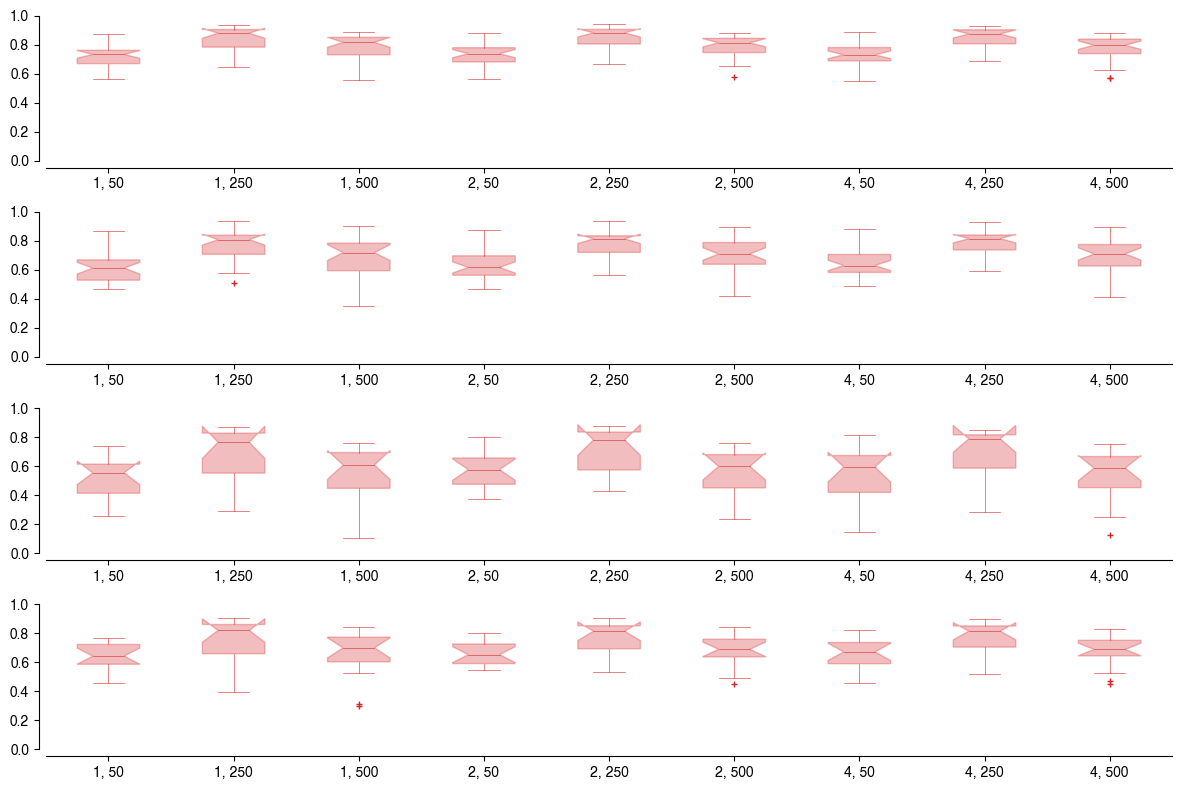

In [62]:
fig = plt.figure(figsize=(12, 8))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(4, 1, j+1)
    _xvals = []
    i = 0
    for _nc in am_param_ranges["nc"]:
        for _nam in am_param_ranges["nam"]:
            _inx1 = am_corr_df[_lmb]["nc"] == _nc
            _inx2 = am_corr_df[_lmb]["nam"] == _nam
            _vals  = am_corr_df[_lmb][_inx1 & _inx2]["r"].values
            _xvals.append(f"{_nc}, {_nam}")
            i += 1 
            ax.boxplot(x=_vals, positions=[i],
                    widths=0.5, notch=True, patch_artist=True,
                    boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                    capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                    markerfacecolor='tab:red', marker='+', markersize=4),
                    medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
            ax.set_ylim(0.0, 1.0)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines['bottom'].set_position(('outward', 5))
    ax.set_xticklabels(_xvals)
            # if _lmb == "left":
            #     ax.set_title("Control: Left", fontsize=12)
            # elif _lmb == "right":
            #     ax.set_title("Control: Reft", fontsize=12)
            # elif _lmb == "aff":
            #     ax.set_title("Stroke: Affected", fontsize=12)
            # else:
            #     ax.set_title("Stroke: Unaffected", fontsize=12)
            
            # if j // 2 == 1:
            #     ax.set_xlabel("Filter window size (samples)", fontsize=12)
            # if j % 2 == 0:
            #     ax.set_ylabel("Correlation Coeff.", fontsize=12)
plt.tight_layout()